In [1]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### CSV/Excel 데이터 분석 agent

Pandas DataFrame 을 활용하여 분석을 수행하는 agent

In [2]:
import pandas as pd

df = pd.read_csv('./data/titanic.csv')          # csv 파일을 데이터프레임으로 만들기
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
from langchain_experimental.tools import PythonAstREPLTool

python_tool = PythonAstREPLTool()               # 파이썬 코드를 실행하는 도구를 생성합니다.
python_tool.locals['df'] = df                   # 데이터프레임(df)을 python_tool.locals['df] 변수에 넣는다.

In [4]:
def tool_callback(tool) -> None:                # 도구 호출 시 실행되는 콜백 함수
    print(f'========= Code =========')

    if tool_name := tool.get('tool'):           # tool.get('tool') 에는 사용된 도구 이름이 있다.
        if tool_name == 'python_repl_ast':      # 사용 도구의 이름이 python_repl_ast 이면
            tool_input = tool.get('tool_input') # 입력 쿼리 (딕셔너리 타입)

            for k, v in tool_input.items():
                if k == 'query':
                    print(f'쿼리 : {v}')        
                    result = python_tool.invoke({"query": v}) 
                    print(f'실행 결과 : {result}')

    print(f'========= Code =========')

In [5]:
def observation_callback(observation) -> None:          # 관찰 결과를 출력하는 콜백 함수
    print(f'========= Message =========')

    if 'observation' in observation:                    
        print(f"관찰 결과 (observation) : {observation['observation']}")    # 실행 결과 출력        
        
    print(f'========= Message =========')

In [6]:
def result_callback(result: str) -> None:
    print(f'========= 최종 답변 =========')
    print(f'최종 답변 : {result}')
    print(f'========= 최종 답변 =========')

In [7]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType
from langchain_teddynote.messages import AgentStreamParser, AgentCallbacks
from langchain_openai import ChatOpenAI

In [8]:
llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)


agent = create_pandas_dataframe_agent(
    llm=llm, 
    df=df, 
    verbose=True, 
    agent_type='tool-calling',
    allow_dangerous_code=True, 

    # 데이터 분석에 필요한 프롬프트를 사전에 가지고 있는데 거기에 추가적으로 요구 사항을 적어준다 
    prefix="You are a professional data analyst and expert in Pandas. "
    "You must use Pandas DataFrame(`df`) to answer user's request. "
    "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code. \n\n"
    "If you are willing to generate visualization code, please use `plt.show()` at the end of your code. "
    "I prefer seaborn code for visualization, but you can use matplotlib as well."
    "\n\n<Visualization Preference>\n"
    "- `muted` cmap, white background, and no grid for your visualization."
    "\nRecomment to set palette parameter for seaborn plot.",
)

In [9]:
parser_callback = AgentCallbacks(tool_callback, observation_callback, result_callback)
stream_parser = AgentStreamParser(parser_callback)

In [10]:
def ask(query):    
    response = agent.stream({'input': query})   # 질의에 대한 답변을 출력합니다.

    for step in response:
        """
        print('========= step =========')

        if 'observation' in step:
            print(step['observation'])
            
        print('========================')
        """
        stream_parser.process_agent_steps(step)



> Entering new None chain...
========= Code =========
쿼리 : import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt='.2f', cmap='muted', square=True, cbar_kws={'shrink': .8})

plt.title('Correlation Heatmap')
plt.show()
실행 결과 : ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'
========= Code =========

Invoking: `python_repl_ast` with `{'query': "import seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Calculate the correlation matrix\ncorr = df.corr()\n\n# Set up the matplotlib figure\nplt.figure(figsize=(10, 8))\n\n# Draw the heatmap with the mask and correct aspect ratio\nsns.heatmap(corr, annot=True, fmt='.2f', cmap='muted', square=True, cbar_kws={'shrink': .8})\n\nplt.title('Correlation Heatmap')\nplt.show()"}`


ValueError: could not convert string to f

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

========= Code =========
쿼리 : import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', square=True, cbar_kws={'shrink': .8})

plt.title('Correlation Heatmap')
plt.show()


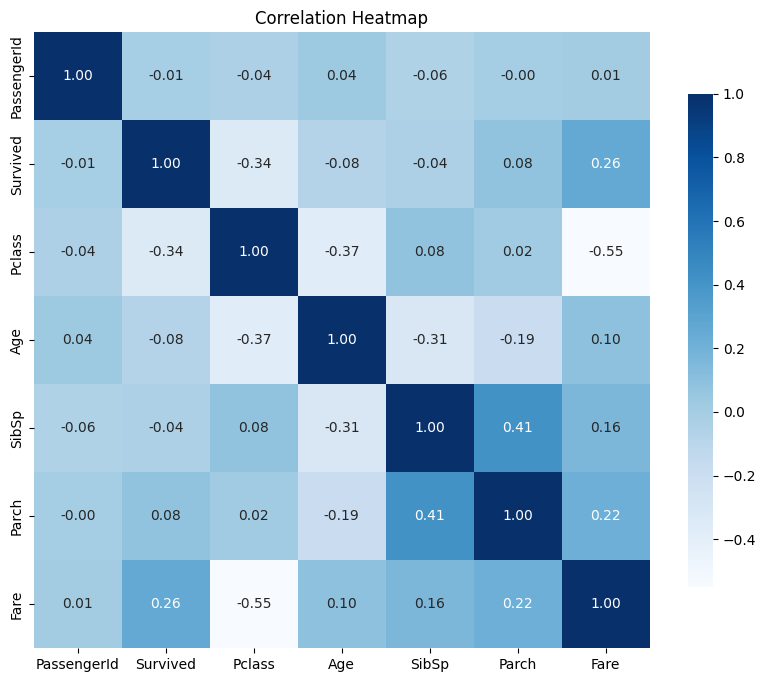

실행 결과 : 
========= Code =========

Invoking: `python_repl_ast` with `{'query': "import seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Select only numeric columns for correlation\nnumeric_df = df.select_dtypes(include=['float64', 'int64'])\n\n# Calculate the correlation matrix\ncorr = numeric_df.corr()\n\n# Set up the matplotlib figure\nplt.figure(figsize=(10, 8))\n\n# Draw the heatmap with the mask and correct aspect ratio\nsns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', square=True, cbar_kws={'shrink': .8})\n\nplt.title('Correlation Heatmap')\nplt.show()"}`




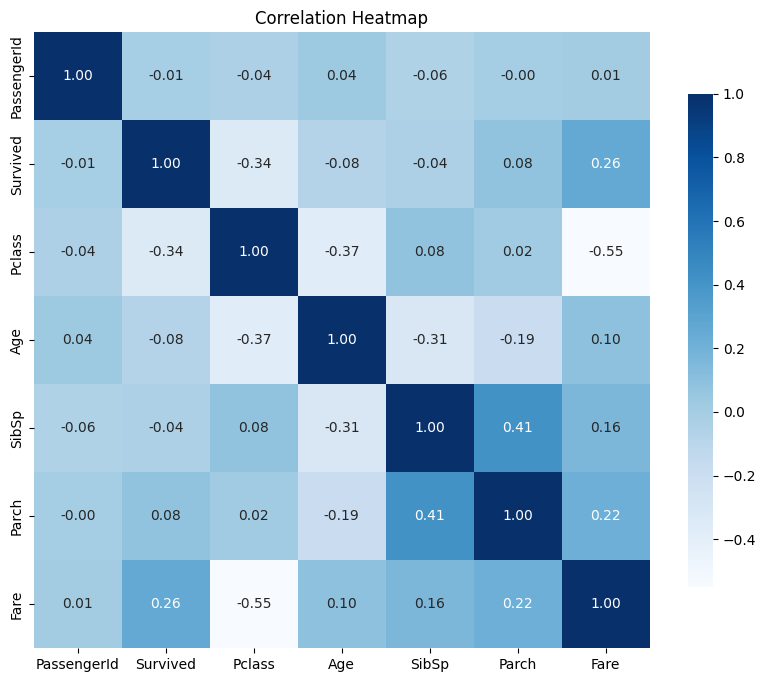

========= Message =========
관찰 결과 (observation) : 
========= Message =========
The correlation heatmap has been generated successfully. It visualizes the relationships between the numeric features in the dataset. If you have any further requests or need additional analysis, feel free to ask!

> Finished chain.
========= 최종 답변 =========
최종 답변 : The correlation heatmap has been generated successfully. It visualizes the relationships between the numeric features in the dataset. If you have any further requests or need additional analysis, feel free to ask!
========= 최종 답변 =========


In [11]:
# 질의에 대한 답변을 출력합니다.
response = agent.stream({'input': 'corr() 을 구해서 히트맵 시각화'})

for step in response:
    stream_parser.process_agent_steps(step)

In [12]:
ask('몇 개의 행이 있어?')



> Entering new None chain...
========= Code =========
쿼리 : len(df)
실행 결과 : 891
========= Code =========

Invoking: `python_repl_ast` with `{'query': 'len(df)'}`


891========= Message =========
관찰 결과 (observation) : 891
========= Message =========
데이터프레임에는 총 891개의 행이 있습니다.

> Finished chain.
========= 최종 답변 =========
최종 답변 : 데이터프레임에는 총 891개의 행이 있습니다.
========= 최종 답변 =========




> Entering new None chain...


<string>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



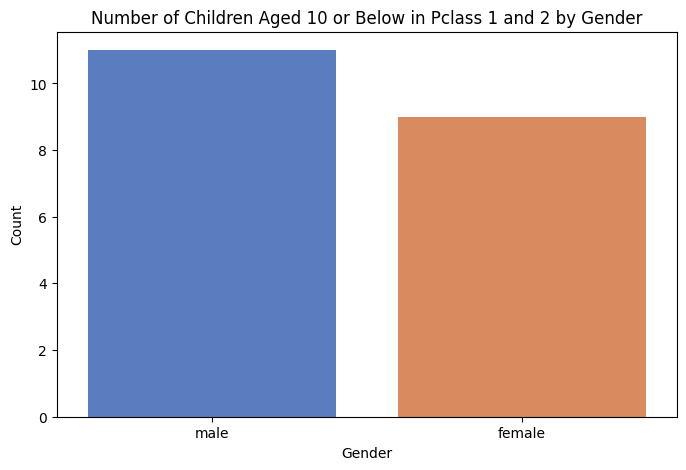

========= Code =========
쿼리 : import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtering the DataFrame for children aged 10 or below in Pclass 1 or 2
children = df[(df['Age'] <= 10) & (df['Pclass'].isin([1, 2]))]

# Counting the number of boys and girls
gender_counts = children['Sex'].value_counts()

# Plotting the results
plt.figure(figsize=(8, 5))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='muted')
plt.title('Number of Children Aged 10 or Below in Pclass 1 and 2 by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
실행 결과 : 
========= Code =========

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Filtering the DataFrame for children aged 10 or below in Pclass 1 or 2\nchildren = df[(df['Age'] <= 10) & (df['Pclass'].isin([1, 2]))]\n\n# Counting the number of boys and girls\ngender_counts = children['Sex'].value_counts()\n\n# 

<string>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



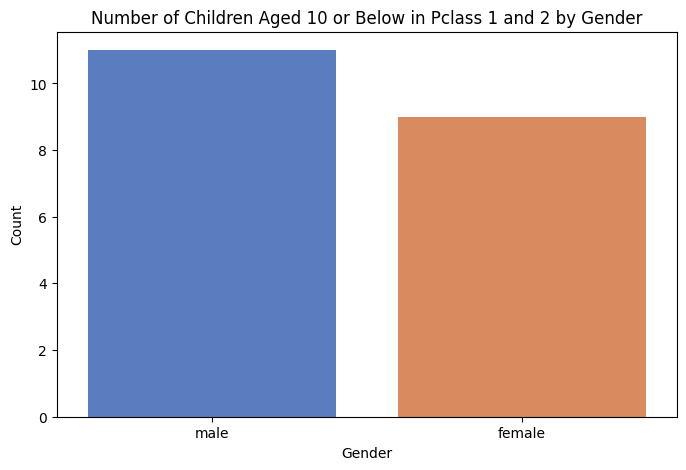

========= Message =========
관찰 결과 (observation) : 
========= Message =========
The visualization has been created, showing the number of children aged 10 or below who were in Pclass 1 and 2, categorized by gender. If you have any further requests or need additional analysis, feel free to ask!

> Finished chain.
========= 최종 답변 =========
최종 답변 : The visualization has been created, showing the number of children aged 10 or below who were in Pclass 1 and 2, categorized by gender. If you have any further requests or need additional analysis, feel free to ask!
========= 최종 답변 =========


In [13]:
ask('1,2 등급에 탑승한 10세 이하 어린 아이의 성별을 구하고 시각화 하세요')

In [16]:
# 질의에 대한 답변을 출력합니다.
response = agent.stream({'input': '20세에서 30세 이하인 여성을 보여주세요'})

for step in response:
    stream_parser.process_agent_steps(step)



> Entering new None chain...
========= Code =========
쿼리 : df[(df['Age'] > 20) & (df['Age'] <= 30) & (df['Sex'] == 'female')]
실행 결과 :      PassengerId  Survived  Pclass  \
2              3         1       3   
8              9         1       3   
41            42         0       2   
53            54         1       2   
56            57         1       2   
..           ...       ...     ...   
858          859         1       3   
866          867         1       2   
874          875         1       2   
880          881         1       2   
882          883         0       3   

                                                  Name     Sex   Age  SibSp  \
2                               Heikkinen, Miss. Laina  female  26.0      0   
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
41   Turpin, Mrs. William John Robert (Dorothy Ann ...  female  27.0      1   
53   Faunthorpe, Mrs. Lizzie (Elizabeth Anne Wilkin...  female  29.0      1   
56          